# Time Series Prediction of  Ice cream and frozen dessert Data.

Data
Info about this data set: https://fred.stlouisfed.org/series/IPN31152N

Units: Index 2012=100, Not Seasonally Adjusted

Frequency: Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation: Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df_1 = pd.read_csv('C:\\Users\\Ashutosh\\Desktop\\TF_2_Notebooks_and_Data\\DATA\\Frozen_Dessert_Production.csv')


In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       573 non-null    object 
 1   IPN31152N  573 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


<b> Date column is object.We want it to be time series

In [4]:
df = pd.read_csv('C:\\Users\\Ashutosh\\Desktop\\TF_2_Notebooks_and_Data\\DATA\\Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [5]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


<b> Rename IPN31152N to Production.

In [7]:
df = df.rename(columns={'IPN31152N': 'Production'})

In [8]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


<b> Plotting the data and seeing the trend in Production.

<AxesSubplot:xlabel='DATE'>

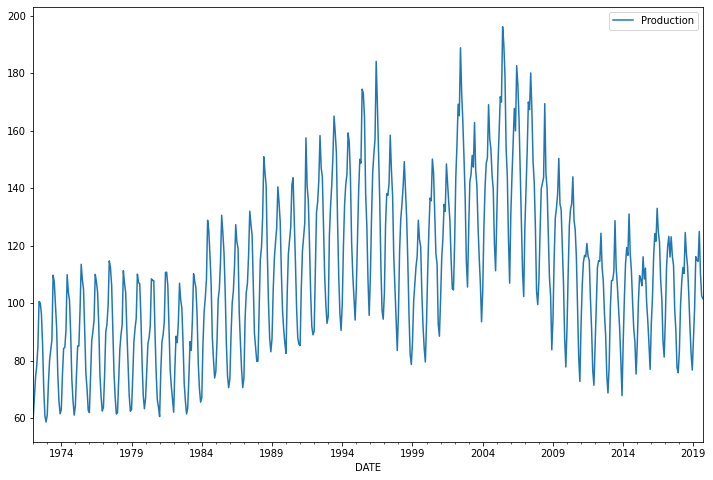

In [9]:
df.plot(figsize=(12,8))

In [10]:
len(df)

573

<b> Let's Keep last 24 months for validation.

In [11]:
test_size = 24

In [12]:
test_idx = len(df) - test_size

In [13]:
train = df.iloc[:test_idx]
test = df.iloc[test_idx:]

In [14]:
len(test)

24

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

<b> Scale the data.

In [17]:
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

<b> Create a Time Series Generator.
    
    Its takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation.

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [22]:
# Creating Our Model

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [27]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

C:\Users\Ashutosh\AppData\Local\Temp/ipykernel_916/3502985036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


Epoch 1/20
531/531 [==============================] - 5s 7ms/step - loss: 0.0275 - val_loss: 0.0108
Epoch 2/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0088 - val_loss: 0.0030
Epoch 3/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 4/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 5/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0034 - val_loss: 0.0030


In [28]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

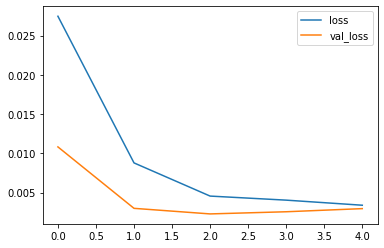

In [29]:
losses.plot()

<b> Evaluate on our validation data.

In [30]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

C:\Users\Ashutosh\AppData\Local\Temp/ipykernel_916/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [33]:
test.head()

,Production,Predictions
DATE,,
2017-10-01,90.4732,89.812072
2017-11-01,77.4378,84.452877
2017-12-01,75.8118,85.971316
2018-01-01,83.4343,93.867610
2018-02-01,99.4899,105.280227


<AxesSubplot:xlabel='DATE'>

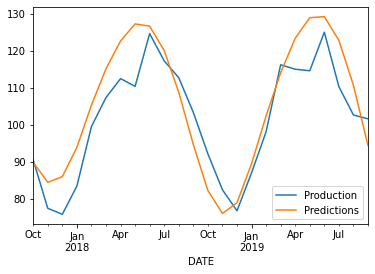

In [34]:
test.plot()

In [35]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

8.118232498976191